# Deep learning Part 2

## Multi-label prediction with Planet Amazon dataset

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *

## Getting the data

* We are going to use a dataset of Kaggle. Remember, Kaggle is a place for machine learning competition. 

* Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API. 
* Just uncomment the following line of code if you need to install the API.

In [ ]:
#!pip3 install kaggle --upgrade

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [ ]:
#! mkdir -p ~/.kaggle/
#! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). 
* You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [ ]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip-full` in your terminal).

In [ ]:
#! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [ ]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

**That was a bit of a pain, but data wrangling always is!**

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [ ]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

* This asks you a series of questions that helps you transform your data. 

In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

For example, to grab the planet data we would say:

- We've got a list of image files that are in a folder
- They're labeled based on a CSV with this name (`train_v2.csv`)
  - They have this separator (` `) ﹣remember I showed you back here that there's a space between them. By passing in separator, it's going to create multiple labels.
  - The images are in this folder (`train-jpg`)
  - They have this suffix (`.jpg`)
- They're going to randomly spit out a validation set with 20% of the data
- We're going to create datasets from that, which we are then going to transform with these transformations (`tfms`)
- Then we're going to create a data bunch out of that, which we will then normalize using these statistics (`imagenet_stats`)

In [ ]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [ ]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

## Understanding Pytorch

### Datasets

![](Images/16.png)

As you can see, it actually does nothing at all. 
The Dataset class in PyTorch defines two things: 
* `__getitem__` and `__len__`. 

In Python these special things that are "underscore underscore something underscore underscore" ﹣Pythonists call them "dunder" something. So these would be "dunder get items" and "dunder len". 
* They're basically special magical methods with some special behavior. This particular method means that your object, if you had an object called `O`, it can be indexed with square brackets (e.g. `O[3]`).  So that would call `__getitem__` with 3 as the index.

Then this one called `__len__` means that you can go `len(o)` and it will call that method. 
* In this case, they're both not implemented. That is to say, although PyTorch says "in order to tell PyTorch about your data, you have to create a dataset", it doesn't really do anything to help you create the dataset. It just defines what the dataset needs to do. In other words, the starting point for your data is something where you can say:

- What is the third item of data in my dataset (that's what `__getitem__` does)
- How big is my dataset (that's what `__len__` does)

Fastai has lots of Dataset subclasses that do that for all different kinds of stuff. So far, you've been seeing image classification datasets. They are datasets where `__getitem__`  will return an image and a single label of what is that image. So that's what a dataset is.

## Dataloader

We need something to create a mini-batch by loading the data.
![](Images/17.png)

A DataLoader takes a dataset in its constructor, so it's now saying "Oh this is something I can get the third item and the fifth item and the ninth item." It's going to:

- Grab items at random
- Create a batch of whatever size you asked for
- Pop it on the GPU
- Send it off to your model for you

So a DataLoader is something that grabs individual items, combines them into a mini-batch, pops them on the GPU for modeling. So that's called a DataLoader and that comes from a Dataset.

You can see, already there are choices you have to make: what kind of dataset am I creating, what is the data for it, where it's going to come from. Then when I create my DataLoader: what batch size do I want to use.  

### Fastai DataBunch

It still isn't enough to train a model. 
* We've got no way to validate the model. 
* If all we have is a training set, then we have no way to know how we're doing because we need a separate set of held out data, a validation set, to see how we're getting along.

![](Images/18.png)

For that we use a fastai class called a DataBunch. 
* Binds together a training data loader (`train_dl`) and a valid data loader (`valid_dl`).  
    * When you look at the fastai docs when you see these mono spaced font things, they're always referring to some symbol you can look up elsewhere. 
    * In this case you can see `train_dl` is the first argument of DataBunch.
    * There's no point knowing that there's an argument with a certain name unless you know what that argument is, so you should always look after the `:` to find out that is a DataLoader. 

**So when you create a DataBunch, you're basically giving it a training set data loader and a validation set data loader. And that's now an object that you can send off to a learner and start fitting**

With the dataset, the indexer returns two things:  the image and the labels (assuming it's an image dataset).

- Where do the images come from?
- Where do the labels come from?
- Then I'm going to create two separate data sets the training and the validation
- `.datasets()` actually turns them into PyTorch datasets
- `.transform()` is the thing that transforms them
- `.databunch()` is actually going to create the the DataLoader and the DataBunch in one go

## DataBlock API

Let's look at some examples of this data block API because once you understand the data block API, you'll never be lost for how to convert your dataset into something you can start modeling with.

Here are some examples of using the data block API. For example, if you're looking at MNIST (the pictures and classes of handwritten numerals), you can do something like this:

In [ ]:
from fastai.gen_doc.nbdoc import *
from fastai.basics import *
np.random.seed(42)
from fastai.vision import *

The data block API lets you customize the creation of a DataBunch by isolating the underlying parts of that process in separate blocks, mainly:

Where are the inputs and how to create them?
1. How to split the data into a training and validation sets?
1. How to label the inputs?
1. What transforms to apply?
1. How to add a test set?
1. How to wrap in dataloaders and create the DataBunch?

Each of these may be addressed with a specific block designed for your unique setup. 
* Your inputs might be in a folder, a csv file, or a dataframe. 
* You may want to split them randomly, by certain indices or depending on the folder they are in. 
* You can have your labels in your csv file or your dataframe, but it may come from folders or a specific function of the input. 
* You may choose to add data augmentation or not. 
* A test set is optional too. Finally you have to set the arguments to put the data together in a DataBunch (batch size, collate function...)

The data block API is called as such because you can mix and match each one of those blocks with the others, allowing for a total flexibility to create your customized DataBunch for training, validation and testing. The factory methods of the various DataBunch are great for beginners but you can't always make your data fit in the tracks they require.

## MNIST Example

In [ ]:
path = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip=False)
path.ls()

In [ ]:
(path/'train').ls()

In [ ]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=64)

This is a shortcut method which is aimed at data that is in **folders following an ImageNet style**, with the train and valid directories, each containing one subdirectory per class, where all the labelled pictures are. There is also a test directory containing unlabelled pictures.

Here is the same code, but this time using the data block API, which can work with any style of a dataset. All the stages, which will be explained below, can be grouped together like this:

In [ ]:
data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

In [ ]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

## Planets Dataset

In [ ]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

### The More Manual Way

In [ ]:
planet = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
data = (ImageList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        #Where to find the data? -> in planet 'train' folder
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(label_delim=' ')
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(planet_tfms, size=128)
        #Data augmentation? -> use tfms with a size of 128
        .databunch())                          
        #Finally -> use the defaults for conversion to databunch

### Reloads the larger dataset

In [ ]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

## What do you do when you have questions?

This notebook is the documentation. 
* You'll find them in [fastai repo in docs_src](https://github.com/fastai/fastai/tree/master/docs_src) . This which you can play with and experiment with inputs and outputs, and try all the different parameters, you will find [the data block API examples of use](https://github.com/fastai/fastai/blob/master/docs_src/data_block.ipynb), if you go to the documentation here it is - the [data block API examples of use](https://docs.fast.ai/data_block.html#Examples-of-use).

Everything that you want to use in fastai, you can look it up in the documentation. There is also search functionality available.

 few interesting points about this.

- **Transforms**: Transforms by default will flip randomly each image, but they'll actually randomly only flip them horizontally. If you're trying to tell if something is a cat or a dog, it doesn't matter whether it's pointing left or right. But you wouldn't expect it to be upside down.  On the other hand for satellite imagery whether something's cloudy or hazy or whether there's a road there or not, could absolutely be flipped upside down. There's no such thing as a right way up from space. So `flip_vert` which defaults to `False`, we're going to flip over to `True` to say you should actually do that. And it doesn't just flip it vertically, it actually tries each possible 90-degree rotation (i.e. there are 8 possible symmetries that it tries out).

- **Warp**: Perspective warping is something which very few libraries provide, and those that do provide it it tends to be really slow. I think fastai is the first one to provide really fast perspective warping. Basically, the reason this is interesting is if I look at you from below versus above, your shape changes. So when you're taking a photo of a cat or a dog, sometimes you'll be higher, sometimes you'll be lower, then that kind of change of shape is certainly something that you would want to include as you're creating your training batches. You want to modify it a little bit each time. Not true for satellite images. A satellite always points straight down at the planet. So if you added perspective warping, you would be making changes that aren't going to be there in real life. So I turn that off.

This is all something called **data augmentation**. We'll be talking a lot more about it later. 

You can start to get a feel for the kind of things that you can do to augment your data. In general, maybe the most important one is if you're looking at astronomical data, pathology digital slide data, or satellite data where there isn't really an up or down, turning on flip verticals true is generally going to make your models generalize better.

## Training a Multilevel Classifier

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. 

In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [ ]:
arch = models.resnet50

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

Then we can fit the head of our network.

In [ ]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(5, slice(lr))

here it's printing out accuracy and this other metric called `fbeta`. If you're trying to figure out how to do a better job with your model, changing the metrics will never be something that you need to do. They're just to show you how you're doing.

You can have one metric, no metrics, or a list of multiple metrics to be printed out as your models training. In this case, I want to know two things:

1. The accuracy.
2. How would I do on Kaggle.

Kaggle told me that I'm going to be judged on a particular metric called the F score. I'm not going to bother telling you about the F score﹣it's not really interesting enough to be worth spending your time on. But it's basically this. When you have a classifier, you're going to have some false positives and some false negatives. How do you weigh up those two things to create a single number? There's lots of different ways of doing that and something called the F score is a nice way of combining that into a single number. And there are various kinds of F scores: F1, F2 and so forth. And Kaggle said in the competition rules, we're going to use a metric called F2.

In [ ]:
learn.save('stage-1-rn50')

We have a metric called `fbeta`. In other words, it's F with 1, 2, or whatever depending on the value of beta. We can have a look at its signature and it has a threshold and a beta. The beta is 2 by default, and Kaggle said that they're going to use F 2 so I don't have to change that. But there's one other thing that I need to set which is a threshold.

What does that mean? Here's the thing. Do you remember we had a little look the other day at the source code for the accuracy metric? And we found that it used this thing called `argmax`. The reason for that was we had this input image that came in, it went through our model, and at the end it came out with a table of ten numbers. This is if we're doing MNIST digit recognition and the ten numbers were the probability of each of the possible digits. Then we had to look through all of those and find out which one was the biggest. So the function in Numpy, PyTorch, or just math notation that finds the biggest in returns its index is called `argmax`.

We can't do that for satellite recognition because there isn't one label we're looking for﹣there's lots. A data bunch has a special attribute called `c` and `c` is going to be how many outputs do we want our model to create. For any kind of classifier, we want one probability for each possible class. In other words, `data.c` for classifiers is always going to be equal to the length of `data.classes`.


In [ ]:
data.c

In [ ]:
len(data.classes)

In [ ]:
data.classes

They are the 17 possibilities. So we're going to have one probability for each of those. But then we're not just going to pick out one of those 17, we're going to pick out *n* of those 17. 

What we do is, we compare each probability to some threshold. Then we say anything that's higher than that threshold, we're going to assume that the models saying it does have that feature. So we can pick that threshold.

I found that for this particular dataset, a threshold of 0.2 seems to generally work pretty well. This is the kind of thing you can easily just experiment to find a good threshold. So I decided I want to print out the accuracy at a threshold of 0.2.

The normal accuracy function doesn't work that way. It doesn't `argmax`. We have to use a different accuracy function called `accuracy_thresh`. That's the one that's going to compare every probability to a threshold and return all the things higher than that threshold and compare accuracy that way.

In [ ]:
accuracy_thresh()

One of the things we had passed in is `thresh`. 

* We want the metric to be calling this function for us, so we don't get to tell it every time it calls back what threshold do we want, so we really want to create a special version of this function that always uses a threshold of 0.2. One way to do that would be defining a function `acc_02` as below:

In [ ]:
def acc_02(inp, targ): return accuracy_thresh(inp, targ, thresh=0.2)

## Python3 `Partials`

We could do it that way. But it's so common that computer science has a term for that called a "partial" / "partial function application" (i.e. create a new function that's just like that other function but we are always going to call it with a particular parameter).

Python3 has something called `partial` that takes some function and some list of keywords and values, and creates a new function that is exactly the same as this function (`accuracy_thresh`) but is always going to call it with that keyword argument (`thresh=0.2`).

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)

This is a really common thing to do particularly with the fastai library because there's lots of places where you have to pass in functions and you very often want to pass in a slightly customized version of a function so here's how you do it.

Similarly, `fbeta` with `thresh=0.2`:

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

* Find the steepest slope and use that as the learning rate

In [ ]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(5, slice(lr))

So we've got an accuracy of about 96% and F beta of about 0.926 and so you could then go and have a look at [Planet private leaderboard](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/leaderboard). The top 50th is about 0.93 so we kind of say like oh we're on the right track. So as you can see, once you get to a point that the data is there, there's very little extra to do most of the time.

In [ ]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.save('stage-2-rn50')

Then we fit a little bit more. Now in this case, I'm fitting with my original dataset. But you could create a new data bunch with just the misclassified instances and go ahead and fit. The misclassified ones are likely to be particularly interesting. So you might want to fit at a slightly higher learning rate to make them really mean more or you might want to run them through a few more epochs. But it's exactly the same thing. You just call fit with your misclassified examples and passing in the correct classification. That should really help your model quite a lot.

When I created my dataset, I put `size=128` and actually the images that Kaggle gave us are 256. 

* I used the size of 128 partially because I wanted to experiment quickly. It's much quicker and easier to use small images to experiment. 

But there's a second reason. I now have a model that's pretty good at recognizing the contents of 128 by 128 satellite images. So what am I going to do if I now want to create a model that's pretty good at 256 by 256 satellite images? 

Why don't I use transfer learning? Why don't I start with the model that's good at 128 by 128 images and fine-tune that? So don't start again. That's actually going to be really interesting because if I trained quite a lot and I'm on the verge of overfitting then I'm basically creating a whole new dataset effectively﹣one where my images are twice the size on each axis right so four times bigger. 

Why don't I use transfer learning? Why don't I start with the model that's good at 128 by 128 images and fine-tune that? So don't start again. That's actually going to be really interesting because if I trained quite a lot and I'm on the verge of overfitting then I'm basically creating a whole new dataset effectively﹣one where my images are twice the size on each axis right so four times bigger. So it's really a totally different data set as far as my convolutional neural networks concerned. So I got to lose all that overfitting. I get to start again. Let's keep our same learner but use a new data bunch where the data bunch is 256 by 256. That's why I actually stopped here before I created my data sets:

In [ ]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

## fin

# Image segmentation with CamVid

* In this example we will create a color coded picture where different context in images are segmented
* We are going to give each pixel a class label
![](Images/c1.png) ![](Images/c2.png)

## Importance of Datasets
* As you can see much of this work is prefaced on having good datasets
* [List of datasets in Fastai](https://course.fast.ai/datasets)

### Loads the reload function

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Imports some functions

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

#### downloads and untars the data

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/trondheim/.fastai/data/camvid/labels'),
 PosixPath('/home/trondheim/.fastai/data/camvid/images'),
 PosixPath('/home/trondheim/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/trondheim/.fastai/data/camvid/codes.txt')]

#### Gets labels and images

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/trondheim/.fastai/data/camvid/images/0016E5_08430.png'),
 PosixPath('/home/trondheim/.fastai/data/camvid/images/Seq05VD_f00780.png'),
 PosixPath('/home/trondheim/.fastai/data/camvid/images/0001TP_008850.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/trondheim/.fastai/data/camvid/labels/Seq05VD_f02220_P.png'),
 PosixPath('/home/trondheim/.fastai/data/camvid/labels/Seq05VD_f04590_P.png'),
 PosixPath('/home/trondheim/.fastai/data/camvid/labels/Seq05VD_f04080_P.png')]

You can see there's some kind of coded file names for the images and some kind of coded file names for the segment masks. Then you kind of have to figure out how to map from one to the other. Normally, these kind of datasets will come with a README you can look at or you can look at their website.

## Look at images

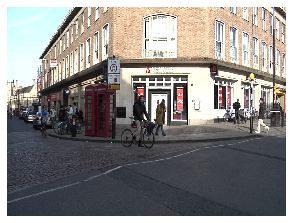

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

**This is a simple function that adds `_P` to the end of the file name. This pulls the labeled data.**

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

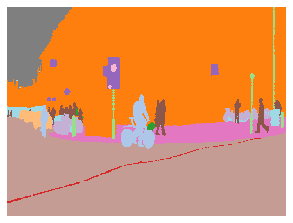

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

* Normally, we use open_image to open a file and then you can go `.show` to take a look at it, but as we described, this is not a usual image file that contains integers. 
* So you have to use open_masks rather than open_image because we want to return integers not floats. fastai knows how to deal with masks, so if you go mask.show, it will automatically color code it for you in some appropriate way. That's why we said `open_masks`.

### Viewing the results

In [15]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ...,  4,  4,  4],
          [21, 21, 21,  ...,  4,  4,  4],
          [21, 21, 21,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

* `codes.tex` provides us with the conversion

In [16]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Settings
* We set the batch size based on the amount of memory on your GPU

In [17]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 20200: bs=8
elif free > 8000: bs=8 
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 22023MB of GPU RAM free


#### Creating a data bunch

To create a data bunch, we can go through the data block API and say:

- We've got a list of image files that are in a folder.
- We then need to split into training and validation. In this case I don't do it randomly because the pictures they've given us are frames from videos. If I did them randomly I would be having two frames next to each other: one in the validation set, one in the training set. That would be far too easy and treating. So the people that created this dataset actually gave us a list of file names (`valid.txt`) that are meant to be in your validation set and they are non-contiguous parts of the video. So here's how you can split your validation and training using a file name file.
- We need to create labels which we can use that `get_y_fn` (get Y file name function) we just created .

In [18]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [19]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

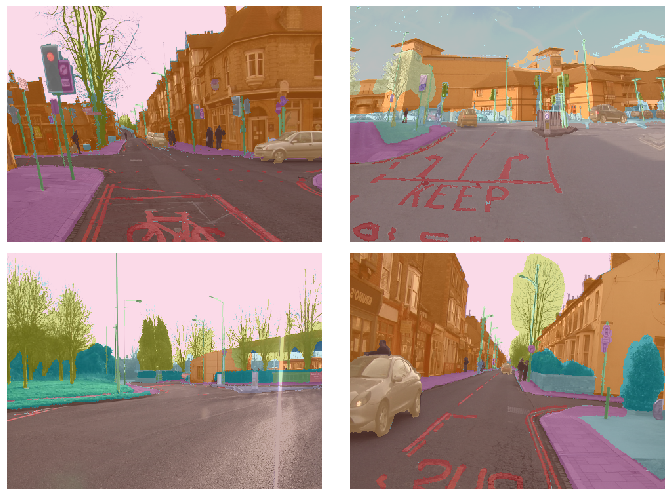

In [20]:
data.show_batch(2, figsize=(10,7))

* We can also look at the validation dataset

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

Once we've got that, we can go ahead and

- Create a learner. I'll show you some more details in a moment.
- Call `lr_find`, find the sharpest bit which looks about 1e-2.
- Call `fit` passing in `slice(lr)` and see the accuracy.
- Save the model.
- Unfreeze and train a little bit more.

### Defines a Quantifable Metric

In [24]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [25]:
metrics=acc_camvid
# metrics=accuracy

In [27]:
wd=1e-2

**This is using a model called UNET. This is the state-of-the-art models for image segmentation**
* Note this model is initially trained on biological images.

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [30]:
lr=3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

#### Fine tuning the entire model

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

* Take a second to internalize what we just did. We just trained a model to segment real world images with 90% per pixel accuracy.


**This is incredibly useful**

# UNET

![](Images/u-net.png)

* The left hand side looks just like a standard CNN
    * It's something which starts with a big image and gradually makes it smaller and smaller until eventually you just have one prediction.
* What a U-Net does is it then takes that and makes it bigger and bigger and bigger again, and then it takes every stage of the downward path and copies it across, and it creates this U shape.

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_lr()

Quite often, they actually go up a bit before they go down. Why is that? That's because (you can also plot your learning rate over time and you'll see that) the learning rate goes up and then it goes down. Why is that? Because we said `fit_one_cycle`. That's what fit one cycle does. It actually makes the learning rate start low, go up, and then go down again.

Remember last week we had two weights we were doing basically <img src="https://latex.codecogs.com/gif.latex?y=ax&plus;b" title="y=ax+b" /> or in his nomenclature <img src="https://latex.codecogs.com/gif.latex?y=w_{0}x&plus;w_{1}" title="y=w_{0}x+w_{1}" />.

#### Learning rate (0.1) 
* Too low
![](Images/jose1.gif)

#### Learning rate (0.7) 
* Jumps quickly to the right value
![](Images/jose2.gif)

#### Learning rate (0.99) 
* Learning rate way too high
![](Images/jose4.gif)

#### Learning rate (1.01) 
* Learning rate way way too high ... diverges
![](Images/jose5.gif)

# Why might increasing the learning rate help? 

* It helps you get out of local minimums.

# What to do when you keep running out of memory? 

You can actually do something called mixed precision training. 
* Mixed precision training means that (for those of you that have done a little bit of computer science) instead of using single precision floating point numbers, you can do most of the calculations in your model with half precision floating point numbers﹣so 16 bits instead of 32 bits. 
* The very idea of this has only been around for the last couple of years﹣in terms of like hardware that actually does this reasonably quickly. 

In [37]:
del learn

In [38]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 20200: bs=8
elif free > 8000: bs=8 
else:           bs=14
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 12708MB of GPU RAM free


In [39]:

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [40]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

In [41]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.633454,0.950052,0.752374,01:48
1,0.950721,0.650578,0.822222,01:31
2,0.753223,0.603814,0.837330,01:31
3,0.638599,0.493119,0.867471,01:31
4,0.643592,0.540221,0.861030,01:32
5,1.500272,1.663616,0.527847,01:31
6,1.198150,0.854701,0.761620,01:31
7,0.865977,0.598285,0.844920,01:31
8,0.660675,0.456844,0.871995,01:31
9,0.540791,0.392104,0.884885,01:31


In [43]:
del learn

# Regression with BIWI head pose dataset
* This dataset has a lot of things included in it, but here we just want to predict a dot in the center of the face.

In [44]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [45]:
from fastai.vision import *

## Getting and converting the data
* Data was used with the xbox kinect. This is a really cool device that has a lot of applications outside of gaming

In [46]:
path = untar_data(URLs.BIWI_HEAD_POSE)

There's some kind of calibration numbers that they provide in a little file which I had to read in

In [48]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [49]:
fname = '09/frame_00667_rgb.jpg'

In [50]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

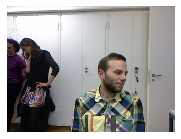

In [51]:
img = open_image(path/fname)
img.show()

In [52]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

Then they provided a little function that you have to use to take their coordinates to change it from this depth sensor calibration thing to end up with actual coordinates

In [53]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [54]:
get_ctr(fname)

tensor([263.9104, 428.5814])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


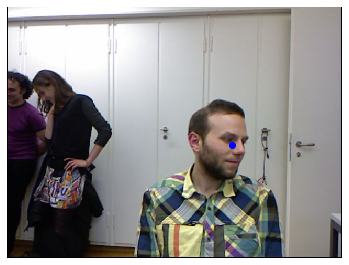

In [63]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))
plt.scatter(ctr[1],ctr[0],c=[0,0,1])

The interesting bit really is where we create something which is not an image or an image segment but an image points. We'll mainly learn about this later in the course, but basically image points use this idea of coordinates. They're not pixel values, they're XY coordinates (just two numbers).
* A lot of people think regression means linear regression, it doesn't. Regression just means any kind of model where your output is some continuous number or set of numbers. So we need to create an image regression model (i.e. something that can predict these two numbers). How do you do that? Same way as always.

## Creating a dataset

We can actually just say:

- I've got a list of image files.
- It's in a folder.
- I'm going to split it according to some function. So in this case, the files they gave us are from videos. So I picked just one folder (`13`) to be my validation set (i.e. a different person). So again, I was trying to think about how do I validate this fairly, so I said the the fair validation would be to make sure that it works well on a person that it's never seen before. So my validation set is all going to be a particular person.
- I want to label them using this function that we wrote that basically does the stuff that the readme says to grab the coordinates out of their text files. So that's going to give me the two numbers for every one.
- Create a dataset. This data set, I just tell it what kind of data set it is ﹣ they're going to be a set of points of specific coordinates.
- Do some transforms. Again, I have to say `tfm_y=True` because that red dot needs to move if I flip or rotate or warp.
- Pick some size. I just picked a size that's going to work pretty quickly.
- Create a data bunch.
- Normalize it.

In [64]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

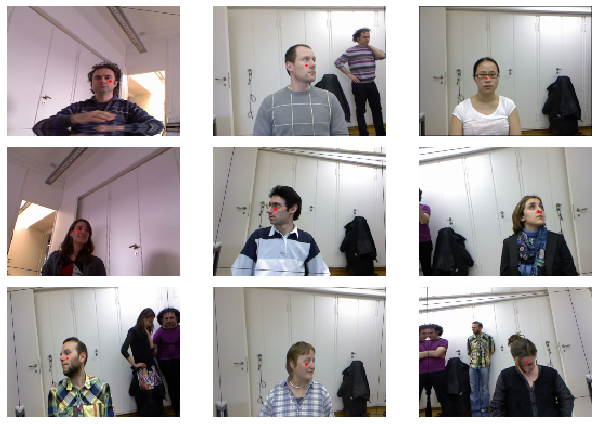

In [65]:
data.show_batch(3, figsize=(9,6))

## Train model

In [66]:
learn = cnn_learner(data, models.resnet34)

In [70]:
learn.loss_func

FlattenedLoss of MSELoss()

So how do we create a model? 
* We create a CNN. We're going to be learning a lot about loss functions in the next few lessons, but basically the loss function is that number that says how good is the model. 
    * **classification** we use this loss function called cross-entropy loss which says basically "Did you predict the correct class and were you confident of that prediction?" 
    * **regression** we use something called mean squared error. If you remember from last lesson, we actually implemented mean squared error from scratch. It's just the difference between the two, squared, and added up together.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


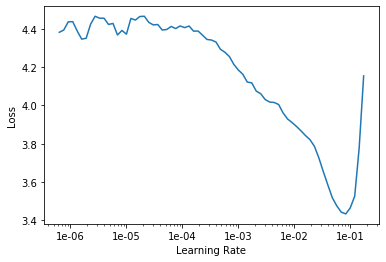

In [67]:
learn.lr_find()
learn.recorder.plot()

In [71]:
lr = 2e-2

In [76]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.006417,0.010857,00:20
1,0.004768,0.000927,00:20
2,0.003036,0.002926,00:20
3,0.002029,0.000787,00:20
4,0.001300,0.000676,00:20


In [77]:
learn.save('stage-1')

In [78]:
learn.load('stage-1');

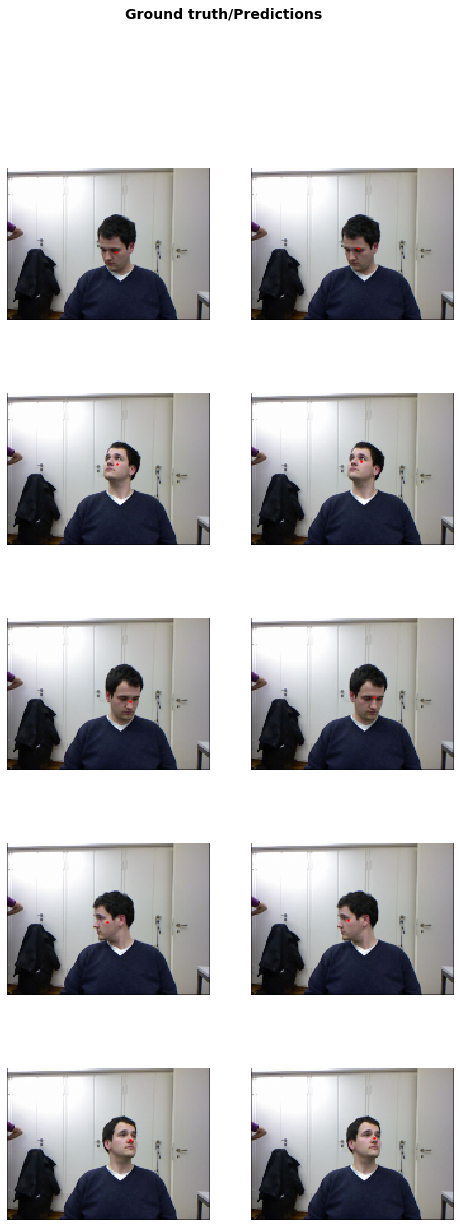

In [79]:
learn.show_results()

## Data augmentation

In [87]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

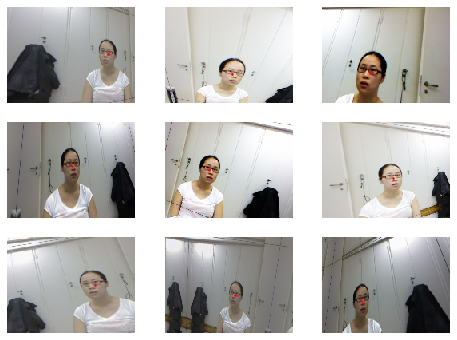

In [88]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))

# Non-linearity

We can't do these complex tasks with just linear models.

Now we know these are deep neural networks. Deep neural networks contain lots of these matrix multiplications, but every matrix multiplication is just a linear model. 
* A linear function on top of a linear function is just another linear function. If you remember back to your high school math, you might remember that if you have a $y = ax + b$ and then you stick another $cy + d$ on top of that, it's still just another slope and another intercept. 
    * So no amount of stacking matrix multiplications is going to help in the slightest.

So what are these models actually? What are we actually doing? And here's the interesting thing﹣all we're actually doing is we literally do have a matrix multiplication (or a slight variation like a convolution that we'll learn about) but after each one, we do something called a non-linearity or an **activation function**. 
* An activation function is something that takes the result of that matrix multiplication and sticks it through some function. These are some of the functions that we use ([by Sagar Sharma](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)):

![](Images/sagar.png)

* In the old days, the most common function that we used to use was **sigmoid**. 
* Nowadays, we nearly always use this one﹣it's called a **rectified linear unit (ReLU)**. 

It's very important, when you're doing deep learning, to use big long words that sound impressive. Otherwise normal people might think they can do it too 😆. But just between you and me,  a rectified linear unit is defined using the following function:

```python
max(x, 0)
```

That's it. And if you want to be really exclusive, of course, you then shorten the long version and you call it a ReLU to show that you're really in the exclusive team. So this is a ReLU activation.

Here's the crazy thing. If you take your red green blue pixel inputs, and you chuck them through a matrix modification, and then you replace the negatives with zero, and you put it through another matrix modification, replace the negatives at zero, and you keep doing that again and again, you have a deep learning neural network. That's it.

#### Universal approximation theorem

So how the heck does that work? 
* An extremely cool guy called Michael Nielsen showed how this works. He has a very nice website (actually a book) http://neuralnetworksanddeeplearning.com and he has these beautiful little JavaScript things where you can get to play around. 
* What he shows is that if you have enough little matrix multiplications followed by sigmoids (exactly the same thing works for a matrix multiplication followed by a ReLU), you can actually create arbitrary shapes. So this idea that these combinations of  linear functions and nonlinearities can create arbitrary shapes actually has a name and this name is the universal approximation theorem.

What it says is that if you have stacks of linear functions and nonlinearities, the thing you end up with can approximate any function arbitrarily closely. So you just need to make sure that you have a big enough matrix to multiply by, or enough of them. If you have this function which is just a sequence of matrix multiplies and nonlinearities where the nonlinearities can be basically any of these activation functions, if that can approximate anything, then all you need is some way to find the particular values of the weight matrices in your matrix multiplies that solve the problem you want to solve. We already know how to find the values of parameters. We can use gradient descent. So that's actually it.